# Forex Trading in Oanda with SMA Crossover Strategy

### Overview
* <h4>OANDA, offers forex and CFD trading, corporate FX payments and exchange rates services.</h4>
* <h4>In this project we will use Oanda API to do forex trading.</h4>
* <h4>We will be using demo account offered by Oanda.</h4>

### Knowledge and Code References


1. <h4>Udemy : Forex strategies for algorithmic trading 2022 - Lucas Inglese</h4>
1. <h4>Udemy : Algorithmic Trading A-Z with Python, Machine Learning & AWS - Alexander Hagmann</h4>
1. <h4>Book : The Art of Currency Trading - Brent Donnelly</h4>
1. <h4>Book : Machine Learning for Algorithmic Trading - Stefan Jansen</h4>

In [1]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import time
import matplotlib.pyplot as plt
import tpqoa

In [10]:
#calling Oanda API through config file
api = tpqoa.tpqoa("oanda.cfg")

The below class is used to automate execution of SMA Crossover strategy in Oanda. When the conditions are met, the decision to buy or sell is automatically taken and positions bought or sold accordingly.

In [3]:
class SMATrader(tpqoa.tpqoa):
    def __init__(self, conf_file, instrument, bar_length, SMA_S, SMA_L, units):
        super().__init__(conf_file)
        self.instrument = instrument
        self.bar_length = pd.to_timedelta(bar_length)
        self.tick_data = pd.DataFrame()
        self.raw_data = None
        self.data = None 
        self.last_bar = None
        self.units = units
        self.position = 0
        self.profits = []
        
        #*****************strategy-specific attributes******************
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        #************************************************************************
    #This method retrieves historical data for EURUSD for specified duration and resamples it
    def get_most_recent(self, days = 5):
        while True:
            time.sleep(2)
            now = datetime.utcnow()
            now = now - timedelta(microseconds = now.microsecond)
            past = now - timedelta(days = days)
            df = self.get_history(instrument = self.instrument, start = past, end = now,
                                   granularity = "S5", price = "M", localize = False).c.dropna().to_frame()
            df.rename(columns = {"c":self.instrument}, inplace = True)
            df = df.resample(self.bar_length, label = "right").last().dropna().iloc[:-1]
            self.raw_data = df.copy()
            self.last_bar = self.raw_data.index[-1]
            if pd.to_datetime(datetime.utcnow()).tz_localize("UTC") - self.last_bar < self.bar_length:
                break
    # This method is called when a new tick (price update) is received. 
    #If a new bar is formed, it triggers resampling, strategy definition, and trade execution            
    def on_success(self, time, bid, ask):
        print(self.ticks, end = " ")
        
        recent_tick = pd.to_datetime(time)
        
        # define stop
        if recent_tick.time() >= pd.to_datetime("11:57").time():
            self.stop_stream = True
        
        
        df = pd.DataFrame({self.instrument:(ask + bid)/2}, 
                          index = [recent_tick])
        self.tick_data = pd.concat([self.tick_data, df]) # new with pd.concat()
        
        if recent_tick - self.last_bar > self.bar_length:
            self.resample_and_join()
            self.define_strategy()
            self.execute_trades()
    
    def resample_and_join(self):
        self.raw_data = pd.concat([self.raw_data, self.tick_data.resample(self.bar_length, 
                                                                          label="right").last().ffill().iloc[:-1]])
        self.tick_data = self.tick_data.iloc[-1:]
        self.last_bar = self.raw_data.index[-1]
    #This method defines a simple trading strategy based on short and long Simple Moving Averages (SMA_S and SMA_L). 
    #The strategy signals whether to go long (1), short (-1), or stay neutral (0)
    def define_strategy(self): # "strategy-specific"
        df = self.raw_data.copy()
        
        #******************** Strategy ************************
        df["SMA_S"] = df[self.instrument].rolling(self.SMA_S).mean()
        df["SMA_L"] = df[self.instrument].rolling(self.SMA_L).mean()
        df["position"] = np.where(df["SMA_S"] > df["SMA_L"], 1, -1)
        #***********************************************************************
        
        self.data = df.copy()
    #This method executes trades based on the defined strategy. 
    #It checks the current position, compares it with the strategy's signal, and executes the appropriate trade order.
    def execute_trades(self):
        if self.data["position"].iloc[-1] == 1:
            if self.position == 0:
                order = self.create_order(self.instrument, self.units, suppress = True, ret = True)
                self.report_trade(order, "GOING LONG")
            elif self.position == -1:
                order = self.create_order(self.instrument, self.units * 2, suppress = True, ret = True) 
                self.report_trade(order, "GOING LONG")
            self.position = 1
        elif self.data["position"].iloc[-1] == -1: 
            if self.position == 0:
                order = self.create_order(self.instrument, -self.units, suppress = True, ret = True)
                self.report_trade(order, "GOING SHORT")
            elif self.position == 1:
                order = self.create_order(self.instrument, -self.units * 2, suppress = True, ret = True)
                self.report_trade(order, "GOING SHORT")
            self.position = -1
        elif self.data["position"].iloc[-1] == 0: 
            if self.position == -1:
                order = self.create_order(self.instrument, self.units, suppress = True, ret = True)
                self.report_trade(order, "GOING NEUTRAL")
            elif self.position == 1:
                order = self.create_order(self.instrument, -self.units, suppress = True, ret = True) 
                self.report_trade(order, "GOING NEUTRAL")
            self.position = 0
    #This method reports details of executed trades, including the timestamp, type of trade (long, short, neutral), 
    #units traded, price, profit and loss (P&L), and cumulative P&L.
    def report_trade(self, order, going):
        time = order["time"]
        units = order["units"]
        price = order["price"]
        pl = float(order["pl"])
        self.profits.append(pl)
        cumpl = sum(self.profits)
        print("\n" + 100* "-")
        print("{} | {}".format(time, going))
        print("{} | units = {} | price = {} | P&L = {} | Cum P&L = {}".format(time, units, price, pl, cumpl))
        print(100 * "-" + "\n")  

While the strategy of using SMA Crossover on day level data is profitable, data at minute level is used here for easy execution.

In [7]:
trader = SMATrader("oanda.cfg", "EUR_USD", "1min", SMA_S = 50, SMA_L = 200, units = 100000)

In [8]:
trader.get_most_recent()
#trader.stream_data(trader.instrument, stop = 3600) 
trader.stream_data(trader.instrument) # no stop after n ticks!
if trader.position != 0: # if we have a final open position
    close_order = trader.create_order(trader.instrument, units = -trader.position * trader.units, 
                                      suppress = True, ret = True) 
    trader.report_trade(close_order, "GOING NEUTRAL")
    trader.position = 0

1 
----------------------------------------------------------------------------------------------------
2023-09-11T11:56:04.555767113Z | GOING SHORT
2023-09-11T11:56:04.555767113Z | units = -100000.0 | price = 1.07184 | P&L = 0.0 | Cum P&L = 0.0
----------------------------------------------------------------------------------------------------

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 
----------------------------------------------------------------------------------------------------
2023-09-11T11:57:00.291818601Z | GOING NEUTRAL
2023-09-11T11:57:00.291818601Z | units = 100000.0 | price = 1.07208 | P&L = -20.4833 | Cum P&L = -20.4833
----------------------------------------------------------------------------------------------------



As we could see from the above based on crossover, short postions was taken. As there was no more change in postion, it went to neutral end on day as it is not profitable to hold open position overnight.

In [9]:
trader.data#.tail(20)

,EUR_USD,SMA_S,SMA_L,position
2023-09-06 11:57:00+00:00,1.074000,NaN,NaN,-1
2023-09-06 11:58:00+00:00,1.074240,NaN,NaN,-1
2023-09-06 11:59:00+00:00,1.074280,NaN,NaN,-1
2023-09-06 12:00:00+00:00,1.074410,NaN,NaN,-1
2023-09-06 12:01:00+00:00,1.074030,NaN,NaN,-1
...,...,...,...,...
2023-09-11 11:52:00+00:00,1.072110,1.072553,1.072807,-1
2023-09-11 11:53:00+00:00,1.072040,1.072533,1.072802,-1
2023-09-11 11:54:00+00:00,1.071950,1.072510,1.072796,-1
2023-09-11 11:55:00+00:00,1.072010,1.072490,1.072792,-1


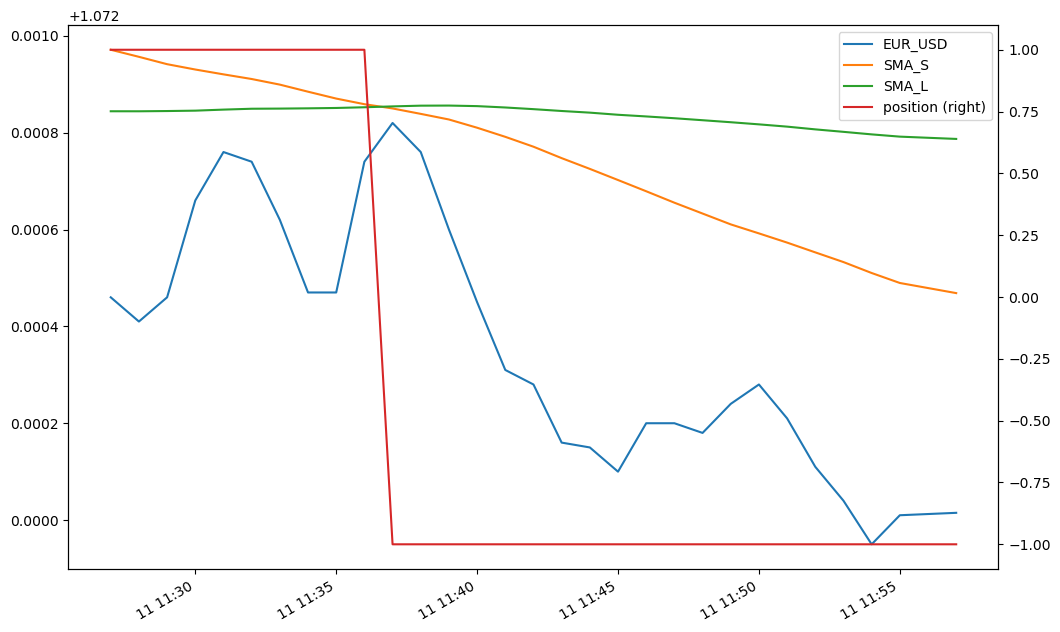

In [10]:
trader.data.tail(30).plot(figsize = (12, 8), secondary_y = "position")
plt.show()

The above chart clearly shows the SMA crossover that happend and change in postion from long to short.

### Conclusion
__Through the above code we were able to automate Forex trading of EURUSD using Oanda.__